# Ensemble Methods

The dataset can be found in the link - https://drive.google.com/drive/folders/1NxCh4X7u7wVo5aHojxjLNs9wC7B7zJhb?usp=sharing

## Introduction

Ensemble methods are popular machine learning procedures because of their performance and interpretability. We will learn to create, fine tune, and interpret the output of the ensemble models.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
# read in the data and display the first 5 rows:
data = pd.read_csv('hmeq-preprocessed.csv')
display(data.head())

,bad_loan,loan_request,amt_due_on_mort,value_of_property,years_at_job,num_derog_reports,num_delinq_lines,oldest_cl_age,num_recent_cl,num_of_cl,debt_to_inc_ratio,reason_for_loan_DebtCon,reason_for_loan_HomeImp,occupation_Mgr,occupation_Office,occupation_Other,occupation_ProfExe,occupation_Sales,occupation_Self
0,1.0,-1.563111,-1.092273,-1.119977,0.204896,-0.287802,-0.390777,-1.010801,-0.105982,-1.245799,0.100426,0,1,0,0,1,0,0,0
1,1.0,-1.545527,-0.083958,-0.611919,-0.263303,-0.287802,1.444855,-0.689082,-0.693180,-0.749574,0.100426,0,1,0,0,1,0,0,0
2,1.0,-1.527943,-1.374281,-1.506102,-0.664616,-0.287802,-0.390777,-0.365411,-0.105982,-1.146554,0.100426,0,1,0,0,1,0,0,0
3,0.0,-1.510359,0.549123,0.142169,-0.798387,-0.287802,-0.390777,-1.022905,-0.693180,-0.749574,0.100426,0,1,0,1,0,0,0,0
4,1.0,-1.510359,-0.985310,-1.097579,0.004239,-0.287802,-0.390777,-0.927646,-0.105982,-1.345045,0.362816,0,1,0,0,1,0,0,0


### Dataset

The data for this assignment is a preprocessed version of the [HMEQ Dataset](https://www.kaggle.com/ajay1735/hmeq-data) from Kaggle.

**FEATURES:**

_Note: All numeric columns are standardized._

- `loan_request`:  The requested loan amount (numeric)
- `amt_due_on_mort`: The amount due on the individual's existing mortgage (numeric)
- `value_of_property`: The value of the current property (numeric)
- `years_at_job`: Number of years at current job (numeric)
- `num_derog_reports`: Number of major derogatory reports (numeric)
- `num_delinq_lines`: Number of delinquent credit lines (numeric)
- `oldest_cl_age`: Age of oldest trade line in standardized months (numeric)
- `num_recent_cl`: Number of recent credit lines (numeric)
- `num_of_cl`: Number of credit lines (numeric)
- `debt_to_inc_ratio`: The individual's debt to income ratio (numeric)
- `reason_for_loan`: The reason for requesting the loan (categorical)
    - `DebtCon`: Debt consolidation
    - `HomeImp`: Home Improvement
- `occupation`: The individual's job title or profession (categorical)
    - `Mgr`: Manager level
    - `Office`: Office worker
    - `Other`: All other professions
    - `ProfExe`: Professional executive
    - `Sales`: Sales professional
    - `Self`: Self employed

**Target:**
- `bad_loan`: Indicates if the individual defaulted on the loan (binary)
    - `1.0`: Default
    - `0.0`: Loan repaid

Using the features above, we will build a number of ensemble models.

### 1. Get the distribution of the target variable using countplot: `bad_loan`

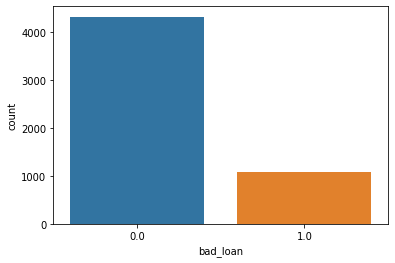

In [ ]:
sns.countplot(x='bad_loan', data=data)
plt.show()

The target variable, `bad_loan`, is **unbalanced** - meaning the variable contains about 4x more "good" loan instances than "bad" loan instances. This can present a problem since the **positive class** we want to predict is the "bad" loan class (`1.0`).

Because of this unbalanced data, we will make sure that both our training set and testing set **maintain this ratio** of good:bad loans. This is acheived by using the `stratify` argument in the `train_test_split()` function, which was imported from the `sklearn.model_selection` module. Also used a random seed value of 42 for reproducibility.

In [ ]:
# separate target variable from features
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

print(data.shape)
print(X.shape)
print(y.shape)

# partition data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42
                                                    )

(5402, 19)
(5402, 18)
(5402,)


### 2. Compute the baseline classification accuracy for `X_train`?
> - HINT: The [DummyClassifier](#https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) may be helpful.
> - Use the `most_frequent` strategy of calculating the baseline accuracy

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train,y_train)
baseline_acc = dummy_classifier.score(X_test,y_test)


### For verifying answer:
print("Baseline Accuracy = ", baseline_acc)

Baseline Accuracy =  0.7988895743368292


## Ensemble Learning

> _"The idea of ensemble learning is to build a prediction model by combining the strengths of a collection of simpler base models._"

An ensemble method (model) is a collection of individual base models that work together to make a single prediction. For a single instance in a dataset, the ensemble algorithm will aggregate the predictions made by each individual base model and produce a single output prediction. This aggregation process varies across different ensemble architectures.

The priciple idea behind using ensemble learning is that this committee of base models working together will outperform a single complex model. There are generally two families of ensemble methods:

- **Averaging Methods**: Build several models independently and average their predictions.
    - Examples: Bagging, Random Forest
- **Boosting Methods**: Sequentially build a series of weak models, where each sequential model attempts to reduce the overall bias of the ensemble.
    - Examples: AdaBoost, Gradient Boosted Trees

There are many advantages to using ensemble methods.
- **Interpretability**: Ensemble methods can be interpreted, although complex ensembles can sometimes make this difficult.
- **High Performance**: Ensemble methods frequently win machine learning competitions
- **Versatility**: Ensembles can be applied to regression or classification tasks

### Ensemble Module: [`sklearn.ensemble`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)

The popular Python machine learning package, `scikit-learn`, maintains an excellent module dedicated to ensemble methods.

## Bagging: _Bootstrap Aggregation_
> "_Bootstrap aggregation,_ or _bagging_, is a general-purpose procedure for reducing the variance of a statistical learning method"

Bagging (short for *Bootstrap Aggregation*) is an averaging ensembling method that involves independently creating a committee of models, each fit on a different sample of training data. The different batches of training data for each base model is _boostrap sample_.

<a id = "bagging-works"></a>
### Why Bagging Works

Decision Trees are a popular choice for the base estimator of a Bagging ensemble. It is very easy to overfit a decision tree to the training data. Furthermore, Decision Trees are known to be _unstable_, meaning a small change in the training data can result in a drastically different Decision Tree.

A tree based Bagging ensemble takes advantage of these shortcomings by fitting each tree on a different bootstrap sample of the training data. Due to the unstable nature of Decision Trees, overfitting each tree to its particular bootstrapped sample will result in an ensemble with a diverse set of trees. While each individual tree is overfit to the data it was trained with, the variance of the overall ensemble is reduced due to this diverse set of trees.

Since boostrapping is fundamental to Bagging, we will learn about that process.

<a id = "bootstrap"></a>
### Bootstrap Sampling

In short, a bootstrap is a randomly drawn sample *with replacement* in which the sample is of the same cardinality as the original dataset. The next question requires to build a function that will produce a single bootstrap DataFrame.

> We will use the function `create_bootstrap_sample` that accepts take a Pandas `DataFrame` as a parameter and returns a bootstrap sample (also as a Pandas `DataFrame`).
> This function will create a single bootstrap sample using `X_train` as input

In [ ]:
def create_bootstrap_sample(df):
    return df.sample(n= df.shape[0], replace = True)

bootstrap_sample = create_bootstrap_sample(X_train)

print('Number of rows should be the same:')
print('Number of rows in X_train:  ', X_train.shape[0])
print('Number of rows in bootstrap:', create_bootstrap_sample(X_train).shape[0])

print(bootstrap_sample)

Number of rows should be the same:
Number of rows in X_train:   3781
Number of rows in bootstrap: 3781
      loan_request  amt_due_on_mort  ...  occupation_Sales  occupation_Self
1436     -0.622366        -1.184610  ...                 0                0
4843      1.021740        -1.432416  ...                 0                0
5308      2.947191        -1.060923  ...                 0                0
1450     -0.613574        -0.430444  ...                 0                0
805      -0.850958        -0.373221  ...                 0                0
...            ...              ...  ...               ...              ...
123      -1.229015        -0.678387  ...                 0                0
592      -0.938878        -0.221927  ...                 0                0
3137     -0.042093        -0.564991  ...                 0                0
1456     -0.613574        -0.062351  ...                 0                0
4626      0.757980         0.544582  ...                 0   

Now that we understand the bootstrapping process, we will next build a generic Bagging ensemble. We will use the [`BaggingClassifier`](#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) class from `scikit-learn` for the next question.

### 3. Use the [`BaggingClassifier`](#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) class from Scikit-Learn, instantiate and fit a model with all the training data.
> **Make sure to set the `random_state` parameter using `BaggingClassifier(random_state=42)` to ensure reproducibility!**

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

model_bagging = BaggingClassifier(random_state = 42)
model_bagging.fit(X_train, y_train)
pred_bagging = model_bagging.predict(X_test)
acc_bagging = accuracy_score(y_test, pred_bagging)

print(' Accuracy = ', acc_bagging)

 Accuracy =  0.8963602714373843


<a id = "classification-metrics"></a>
### Classification Metrics Review
An important consideration when evaluating classfier models is how well the model is predicting the "positive" class. In this case, the `1.0` value in the `bad_loan` column will be designated as the positive class.

*Note*: Don't confuse the word "positive" in this case to mean "optimistic". The meaning of "positive" in this context simply means the focus is on identifying default loans (avoiding losses) rather than profitable loans.  The same would be true for a "positive" test result for an illness or a "positive" pregnancy test.

Accuracy does not tell the whole story when evaluating a classifier model with **unbalanced** data. It's likely that the model is better at predicting the the majority class (`0.0`) because there are more samples for that class. We need to look at a few more evaluation metrics to understand how well the model predicts the "positive" class:
<br>
<br>
$$
\begin{align}
\text{accuracy} = \frac{\mathtt{tp} + \mathtt{tn}}{\mathtt{tn} + \mathtt{tp} + \mathtt{fn} + \mathtt{fp}}
\end{align}
$$
<br>
<br>
$$
\begin{align}
\text{recall} = \frac{\mathtt{tp}}{\mathtt{tp} + \mathtt{fn}}
\end{align}
$$
<br>
<br>
$$
\begin{align}
\text{precision} = \frac{\mathtt{tp}}{\mathtt{tp} + \mathtt{fp}}
\end{align}
$$
<br>
<br>

where $\mathtt{tn}$, $\mathtt{tp}$, $\mathtt{fn}$, and $\mathtt{fp}$ are the number of true negatives, true positives, false negatives, and false positives respectively.
<br>
<br>
<br>
<style>
table {align:left;display:block}
</style>


| $$\textbf{Metric}$$ | $$\textbf{Meaning for this Model}$$ |
| :------| :----- |
| $$\mathtt{tp}$$ | $$\text{Number of actual bad loans predicted to be bad loans - the bank avoids losses.}$$ |
| $$\mathtt{tn}$$ | $$\text{Number of actual good loans predicted to be good loans - the bank earns profit.}$$ |
| $$\mathtt{fp}$$ | $$\text{Number of actual bad loans predicted to be good loans (false alarms!) - bank loses  money.)}$$ |
| $$\mathtt{fn}$$ | $$\text{Number of actual good loans predicted to be bad loans - the bank misses opportunity to earn money.}$$ |


<br>
Depending on the use case, you may decide to optimize either $\text{recall}$ or $\text{precision}$. For example, consider a model that predicts if a tumor is malignant (positive class) or benign (negative class) from an ultrasound image. In this case, a $\mathtt{fn}$ is much more costly than a $\mathtt{fp}$, so $\text{recall}$ is more important than $\text{precision}$. The opposite situation could be true for a model that predicts when to replace expensive machinery parts. Machine learning metrics and business/health metrics are not always the same thing. Always consider the true cost you should optimize when model building.

The `scikit-learn.metrics` module conveniently provides functions that will calculate these metrics:

- [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), 
- [`recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)
- [`precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html).

The below cell block demonstrates the `classification_report()` function to evaluate the entire Bagging ensemble.

In [ ]:
from sklearn.metrics import (
    classification_report,
    recall_score,
    precision_score,
    accuracy_score
)
print('Classification Report:\n')
print(classification_report(y_test, pred_bagging))

Classification Report:

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94      1295
         1.0       0.80      0.64      0.71       326

    accuracy                           0.90      1621
   macro avg       0.86      0.80      0.83      1621
weighted avg       0.89      0.90      0.89      1621



`scikit-learn` provides users the ability to investigate the individual base models within an ensemble with the `.estimator_` attribute. Let's investigate the recall testing performance using each of the individual base models, which are `DecisionTreeClassifiers` by default.

In [ ]:
def print_recall_scores(ensemble, feats, true_labels):
    '''
    Prints the recall scores for base estimators in a sklearn ensemble model.
    '''
    scores = []
    for model_idx, model in enumerate(ensemble.estimators_):
        if model_idx == 0:
            print('='*40)
        preds = model.predict(feats)
        scores.append(recall_score(true_labels, preds))
        model_recall = np.round(recall_score(true_labels, preds), 5)
        print(f'Recall for Base Model {model_idx+1}:\t', model_recall)
        if model_idx < (len(ensemble.estimators_) - 1):
            print('-'*40)
        else:
            print('='*40)
    ensemble_preds = ensemble.predict(feats)
    print("Mean Recall Score:\t\t", np.round(np.array(scores).mean(), 5))
    print("Std Deviation:\t\t\t", np.round(np.array(scores).std(), 5))
    print("Range:\t\t\t\t", np.round(np.array(scores).ptp(), 5))
    print(f'Overall Recall for model:\t {np.round(recall_score(y_test, ensemble_preds), 5)}')

In [ ]:
print_recall_scores(model_bagging, X_test, y_test)

Recall for Base Model 1:	 0.61963
----------------------------------------
Recall for Base Model 2:	 0.62577
----------------------------------------
Recall for Base Model 3:	 0.6227
----------------------------------------
Recall for Base Model 4:	 0.61043
----------------------------------------
Recall for Base Model 5:	 0.59816
----------------------------------------
Recall for Base Model 6:	 0.64417
----------------------------------------
Recall for Base Model 7:	 0.60429
----------------------------------------
Recall for Base Model 8:	 0.61656
----------------------------------------
Recall for Base Model 9:	 0.66258
----------------------------------------
Recall for Base Model 10:	 0.61963
Mean Recall Score:		 0.62239
Std Deviation:			 0.01791
Range:				 0.06442
Overall Recall for model:	 0.64417


Notice that the recall on each individual tree is very similar.

The generic Bagging ensemble method will now be compared to a Random Forest model, which is a variant of the standard Bagging method.

### Random Forest

> "Random Forests is a substantial modification of bagging that builds a large collection of _de-correlated_ trees, and averages them."

When constructing a tree within a bagging ensemble, all input features are considered to determine the best split. If the data contains one or two dominant features, those dominant features are always selected first in every tree within the ensemble, resulting in a high correlation among the trees.

The Random Forest algorithm further reduces the model error due to variance by de-correlating each tree within the ensemble. This is acheived by considering only a sample of features from the available feature set at each split in the decision tree. This procedure results in a higher diversity of trees within the ensemble, which can reduce the overall variance.

#### Question 4

> We will now build a Random Forest model using the [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) class from `scikit-learn`.
> - Instantiate a `RandomForestClassifier` using the constructor arguments: `n_estimators=10`, `max_features=7` and `random_state=42`, i.e., `RandomForestClassifier(n_estimators=10, max_features=7, random_state=42)`.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=10, max_features=7, random_state=42)
model_rf.fit(X_train, y_train)
predict_rf = model_rf.predict(X_test)
recall_rf = recall_score(y_test, predict_rf)
precision_rf = precision_score(y_test, predict_rf)

The implementation of Random Forest should de-correlate the trees from each other, resulting in a higher variance in performance on `X_test` when we look at each individual tree in the ensemble.

In [ ]:
print_recall_scores(model_rf, X_test, y_test)

Recall for Base Model 1:	 0.63804
----------------------------------------
Recall for Base Model 2:	 0.65031
----------------------------------------
Recall for Base Model 3:	 0.64724
----------------------------------------
Recall for Base Model 4:	 0.63804
----------------------------------------
Recall for Base Model 5:	 0.60123
----------------------------------------
Recall for Base Model 6:	 0.6319
----------------------------------------
Recall for Base Model 7:	 0.64724
----------------------------------------
Recall for Base Model 8:	 0.59509
----------------------------------------
Recall for Base Model 9:	 0.68098
----------------------------------------
Recall for Base Model 10:	 0.61963
Mean Recall Score:		 0.63497
Std Deviation:			 0.02376
Range:				 0.08589
Overall Recall for model:	 0.63804


The `BaggingClassifier` and `RandomForestClassifier` have similar overall recall scores, but the variance of recall scores among the individual Decision Trees is higher in the Random Forest due to the additional sampling of the feature space as the trees are constructed. The trees within the Random Forest model are more diverse.

<a id = "oob"></a>
### Out-of-Bag Evaluation

Through the process of bootstrap sampling, some instances can be sampled multiple times, while other instances are left out of the sample altogether. The samples that are left out of the bootstrap sample are known as "out-of_bag" (oob) samples. Since these observations are not used during the training of a particular base learner, the oob instances can be used as testing samples. This eliminates the need to withhold data from training for the purpose of evaluation.

Ensemble models in `scikit-learn` contain a parameter in the model constructors called `oob_score`. Setting `oob_score=True` will enable this implementation. After fitting the model, the evaluation results can be found in the attribute `.oob_score_`.

Next create another `RandomForestClassifier` model using `X_train`, but 
this time setting the `oob_score` parameter to `True`. You will then compare the 
oob accuracy score to the accuracy of the model on `X_test`.
> - Instantiate and fit a `RandomForestClassifier` model to `X_train`.
Use the following constructor arguments: `n_estimators=100`, `max_features=7`, `oob_score=True`, and `random_state=42`

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rf_oob = RandomForestClassifier(n_estimators=100, max_features=7, oob_score=True, random_state=42).fit(X_train, y_train)
oob_score = round(model_rf_oob.oob_score_,4)
acc_oob = round(accuracy_score(y_test, model_rf_oob.predict(X_test)),4)
diff_oob = round(abs(oob_score - acc_oob),4)

print('OOB Score:\t\t\t', oob_score)
print('Testing Accuracy:\t\t', acc_oob)
print('Acc. Difference:\t\t', diff_oob)

OOB Score:			 0.9127
Testing Accuracy:		 0.9155
Acc. Difference:		 0.0028


## Boosting
> "Boosting is one of the most powerful learning ideas introduced in the last twenty years."

Boosting is fundamentally different than bagging. Bagging ensembles attempt to reduce overall _variance_ by fitting models independently on bootstapped samples. Boosting methods attempt to reduce _bias_ by sequentially improving the overall predictions. That is, base learner $m$ attempts to correct the predictions produced by the base learner $m-1$, for $m=1$ to $M$.

### AdaBoost

One of the prototypical boosting algorithms was Adaptive Boosting, or AdaBoost. The AdaBoost algorithm begins by assigning equal weights to every observation in the training data. The base learner in the ensemble is fit on the training data and produces predictions. Based on these predictions, the weights are adjusted to increase for misclassified observations and reduced for correctly classified observations. Each model repeats this procedure of making predictions and updating the weights accordingly.

The principle idea behind AdaBoost is that difficult to predict cases get assigned a heavier and heavier weight so that base learners futher down the ensemble become better at predicting them. We will now practice building and evaluating an AdaBoost model in `scikit-learn`.

> We will build two AdaBoost models with TRAINING data using the [`AdaBoostClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) class from `scikit-learn` and report the best `recall_score()` on TESTING.
>
> "MODEL 1" Hyperparameters:
> - Use `DecisionTreeClassifier(max_depth=2)` as base estimator
> - Set `n_estimators=500`
> - Set `random_state=42`
> - Set `learning_rate = 0.05`
>
> "MODEL 2" Hyperparameters::
> - Use `DecisionTreeClassifier(max_depth=2)` as base estimator
> - Set `n_estimators=20`
> - Set `random_state=42`
> - Set `learning_rate = 0.5`

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
base_est = DecisionTreeClassifier (max_depth =2)
ada_boost1 = AdaBoostClassifier(base_est, n_estimators=500, random_state=42, learning_rate=.05)
ada_boost1.fit(X_train, y_train)
ada_boost2 = AdaBoostClassifier(base_est, n_estimators=20, random_state=42, learning_rate=.5)
ada_boost2.fit(X_train, y_train)
res1 = round(recall_score(y_test, ada_boost1.predict(X_test)),4)
res2 = round(recall_score(y_test, ada_boost2.predict(X_test)),4)

print('Winning Model:\t {}, MODEL 1')
print('MODEL 1 Recall:\t {}'.format(res1))
print('MODEL 2 Recall:\t {}:'.format(res2))

Winning Model:	 {}, MODEL 1
MODEL 1 Recall:	 0.6933
MODEL 2 Recall:	 0.6411:


### Gradient Boosted Trees (GBT)

An extremely popular boosting algorithm is Gradient Booosted Trees. Instead of re-weighting observations based on the prediction performance, Gradient Boosted Trees attempt to correct the residuals errors of the preceding models. The initial base estimator is fit on the training data. From then on, subsequent model is fit on the previous model's residuals.

> We will now create `GradientBoostingClassifier` model using `X_train` & `y_train`.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)
gbc_pred = gbc.predict(X_test)
recall_gbc = round(recall_score(y_test, gbc_pred),4)
precision_gbc = round(precision_score(y_test, gbc_pred),4)

print('Recall :\t {}'.format(recall_gbc))
print('Precision :\t {}:'.format(precision_gbc))

Recall :	 0.6595
Precision :	 0.8333:


<a id = "feature-importance"></a>
## Feature Importance

A fantastic characteristic of many ensemble models is that you have the ability to interpret the feature importance. As you learned with Decision Trees, the most important features are selected first during the construction of a tree. Using the gini or information gain generated from using a feature to make a split, a feature importance score can be calculated.

In the case of ensembles, these feature importance scores are aggregated over all of the trees within the ensemble. `scikit-learn` conveniently calculates a `.feature_importance_` score for many of their ensemble implementations.

Find the most important feature from the fitted Random Forest model

In [ ]:
feature_importances = model_rf.feature_importances_
features = X_train.columns
df = pd.DataFrame({'features': features, 'importance': feature_importances}).nlargest
print(df)

<bound method DataFrame.nlargest of                    features  importance
0              loan_request    0.075351
1           amt_due_on_mort    0.069732
2         value_of_property    0.074060
3              years_at_job    0.061340
4         num_derog_reports    0.076399
5          num_delinq_lines    0.099279
6             oldest_cl_age    0.102369
7             num_recent_cl    0.032601
8                 num_of_cl    0.078266
9         debt_to_inc_ratio    0.279206
10  reason_for_loan_DebtCon    0.006666
11  reason_for_loan_HomeImp    0.006930
12           occupation_Mgr    0.006902
13        occupation_Office    0.007598
14         occupation_Other    0.008467
15       occupation_ProfExe    0.005364
16         occupation_Sales    0.004561
17          occupation_Self    0.004909>


## Ensemble of several different types of models

We use the Voting Classifier from sklearn for this technique. 

We will use an ensemble of RandomForestClassifier, Support Vector Machine and Logistic Regression.

### Voting Classifier

There are two types of voting used to aggregate the output of all the weak learners.

Hard voting — If we receive the output of each weak learner in classes (for e.g: 0/1), and finally we select the output class which was returned in majority, then this method is called hard voting.

Soft voting — There are many algorithms which also provide us with prediction probabilities and if we receive the output in probabilities, we take the average of the probabilities of each of the classes and whichever class is having the highest average will be the final prediction. This way of prediction is called Soft voting and is better than hard voting as we receive more information in terms of probability.
Another important thing to remember is, this method of voting is used as a default technique for ensembles like random forest.


Let’s understand these two concepts using below diagrams where 1 is class 1 and 0 is class 0.

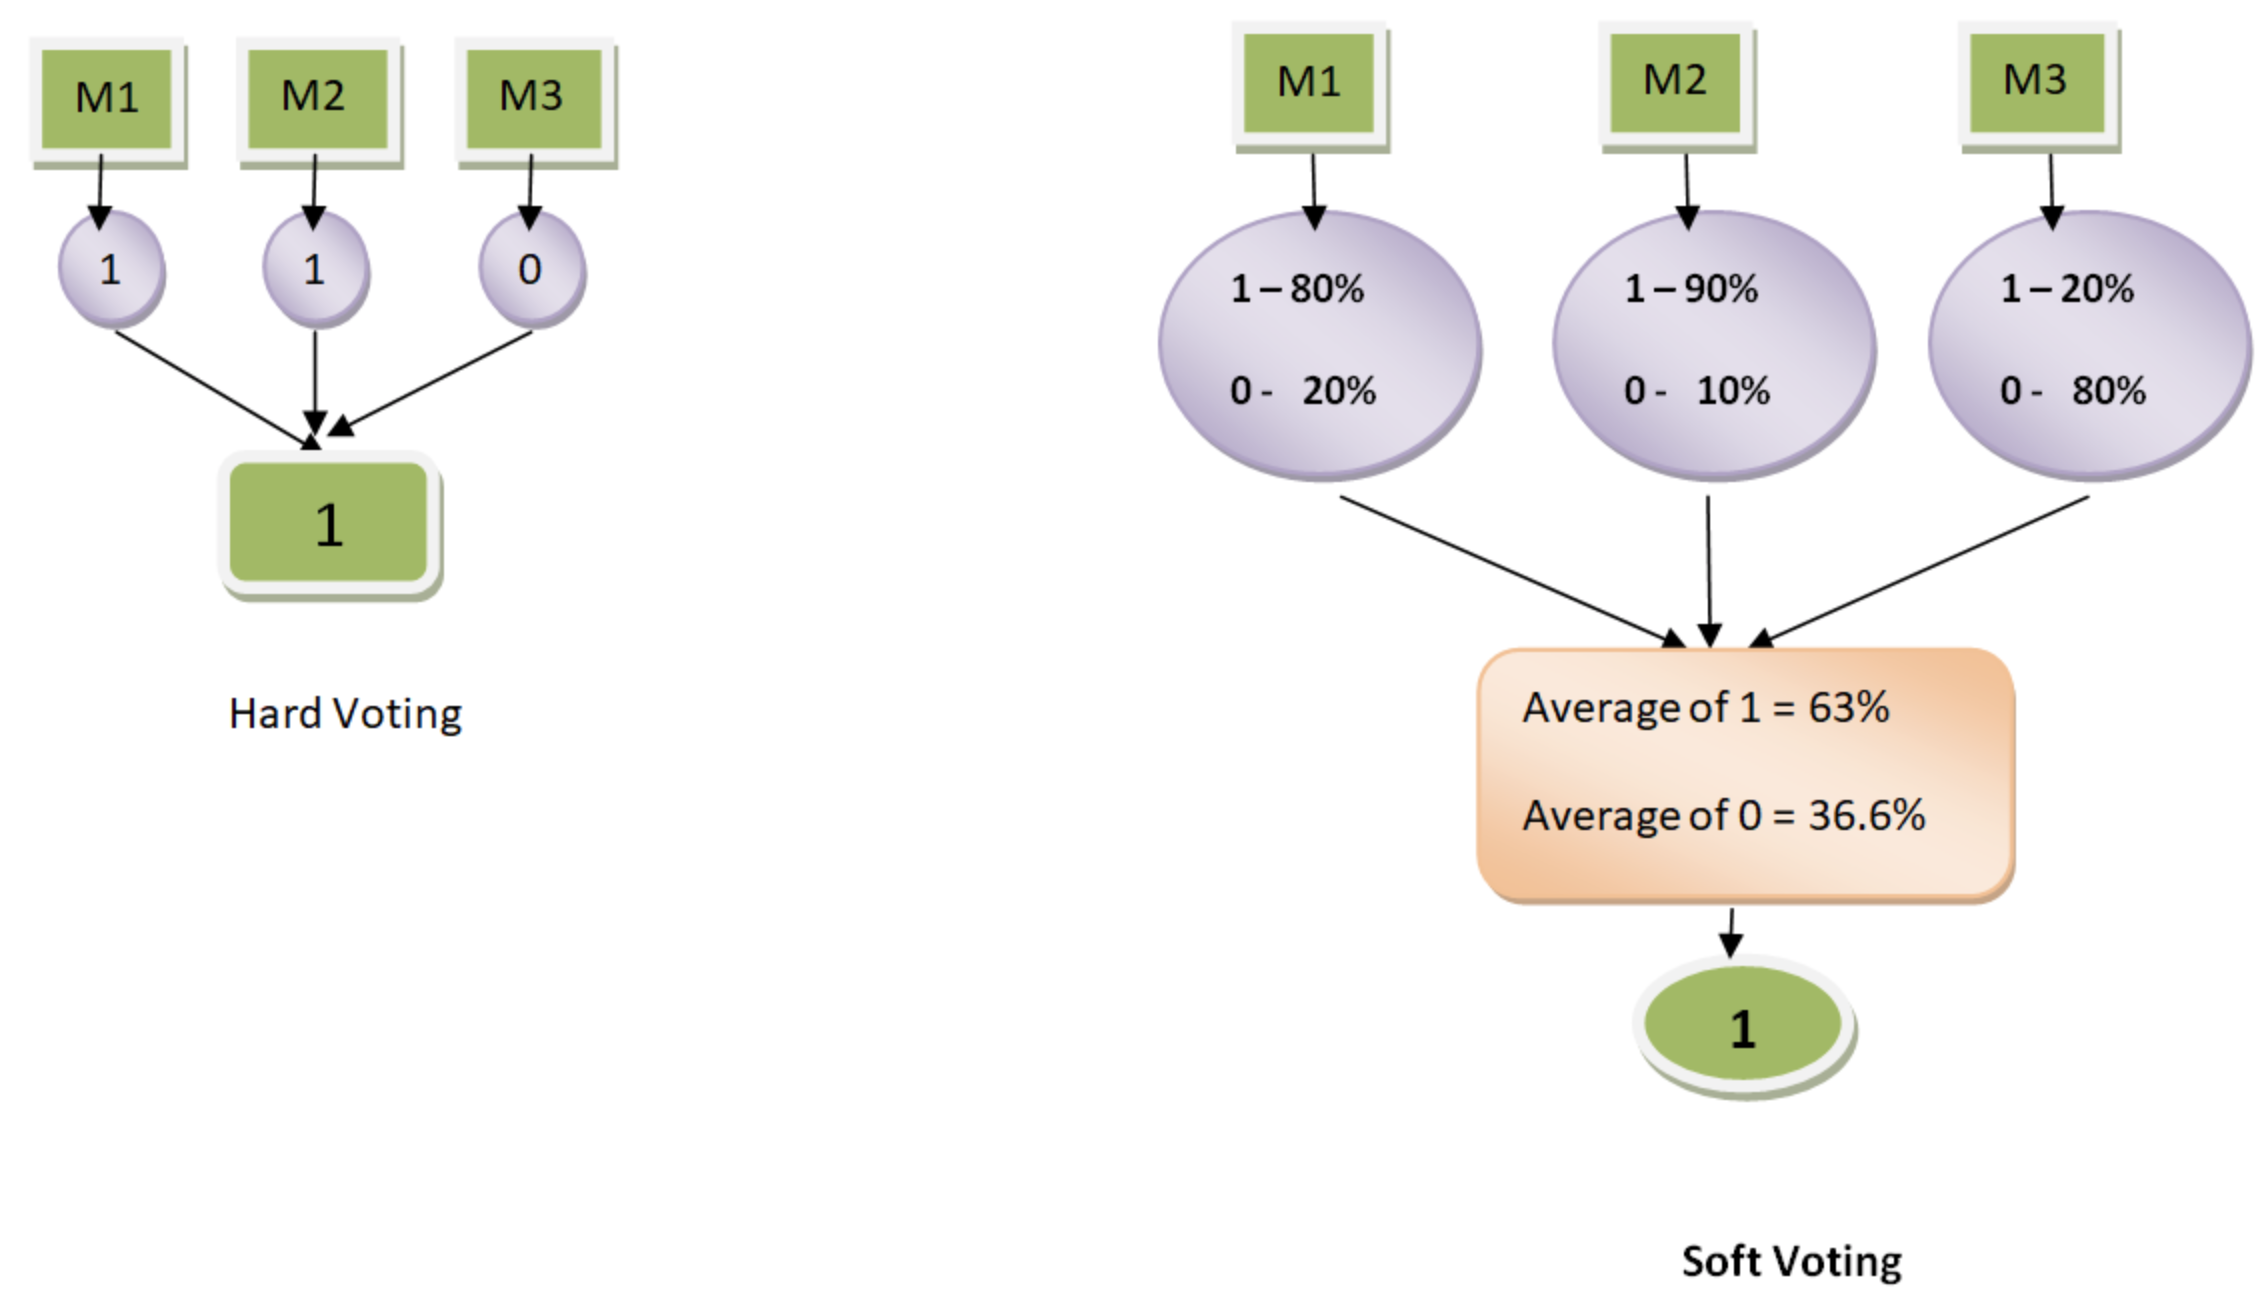

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

rfClf = RandomForestClassifier(n_estimators=500, random_state=0) # 500 trees. 
svmClf = SVC(probability=True, random_state=0) # probability calculation
logClf = LogisticRegression(random_state=0)

# constructing the ensemble classifier by mentioning the individual classifiers.
clf2 = VotingClassifier(estimators = [('rf',rfClf), ('svm',svmClf), ('log', logClf)], voting='soft') 

# train the ensemble classifier
clf2.fit(X_train, y_train)

clf2_pred = clf2.predict(X_test)
recall_voting = recall_score(y_test, clf2_pred)
precision_voting = precision_score(y_test, clf2_pred)
print('Accuracy score', accuracy_score(y_test, clf2_pred))

# You can use the individual classifiers to get the accuracy in the beginning and see if our ensemble performs
# better when compared to individual classifiers.